<a href="https://colab.research.google.com/github/Chao-Meng/optimization/blob/main/phase2-updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

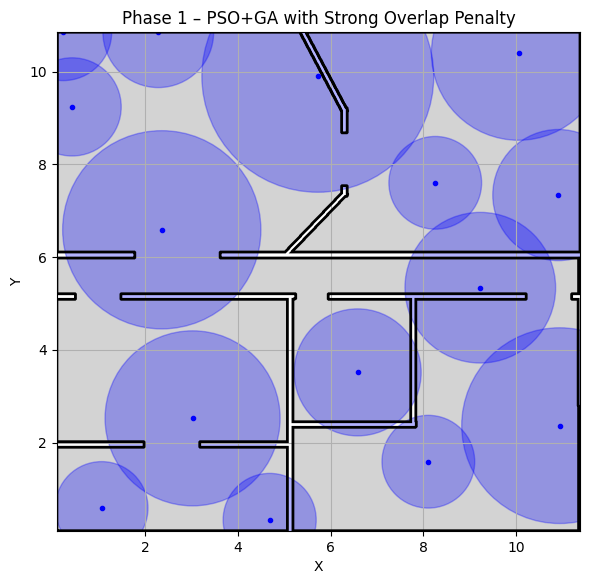

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Polygon
from matplotlib.path import Path

# --------------------- Load Layout ---------------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]
layout_poly    = Path(polygon_coords)

# --------------------- Parameters ---------------------
num_sensors         = 15
sensor_radius_bounds = (1.0, 2.5)
num_particles       = 30
num_iterations      = 80

# PSO+GA hyperparams
w_inertia     = 0.7
c1, c2        = 1.4, 1.4
ga_generations = 5
mutation_rate  = 0.1

# 重叠惩罚权重（增大） & 重叠点数惩罚 & 半径成本
w_overlap      = 2.0    # 之前是 0.5，调大
w_overlap_pts  = 1.0    # 新增：每个网格点被 ≥2 个传感器覆盖的惩罚
w_radius       = 0.1

# --------------------- Prepare Grid ---------------------
grid_resolution = 0.2
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)
xx, yy  = np.meshgrid(x_coords, y_coords)
GRID    = np.c_[xx.ravel(), yy.ravel()]
valid   = layout_poly.contains_points(GRID)

# --------------------- Fitness Function ---------------------
def evaluate_solution(sol):
    cov = np.zeros(len(GRID), dtype=int)
    radius_cost = 0.0

    # 累积覆盖与半径成本
    for i in range(num_sensors):
        x, y, r = sol[3*i:3*i+3]
        if not layout_poly.contains_point((x, y)):
            return np.inf
        d = np.hypot(GRID[:,0]-x, GRID[:,1]-y)
        mask = (d <= r)
        cov += mask.astype(int)
        radius_cost += r

    cov = cov * valid
    unique_cov   = np.sum(cov > 0)
    overlap_cov  = np.sum(cov) - unique_cov
    overlap_pts  = np.sum(cov > 1)  # 被至少 2 个传感器覆盖的网格点数

    # 目标：最小化如下式
    #  - unique_cov   (最大化覆盖)
    #  + w_overlap*overlap_cov
    #  + w_overlap_pts*overlap_pts
    #  + w_radius*radius_cost
    fitness = (
        - unique_cov
        + w_overlap * overlap_cov
        + w_overlap_pts * overlap_pts
        + w_radius * radius_cost
    )
    return fitness

# --------------------- PSO + GA Setup ---------------------
dim = num_sensors * 3
lb  = np.tile([min_x, min_y, sensor_radius_bounds[0]], num_sensors)
ub  = np.tile([max_x, max_y, sensor_radius_bounds[1]], num_sensors)

# 初始化粒子
pos    = np.random.uniform(lb, ub, (num_particles, dim))
vel    = np.zeros_like(pos)
pbest  = pos.copy()
pval   = np.array([evaluate_solution(p) for p in pos])
gbest  = pbest[np.argmin(pval)].copy()
gval   = np.min(pval)

# --------------------- Hybrid PSO + GA Loop ---------------------
for _ in range(num_iterations):
    # PSO 更新
    for i in range(num_particles):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        vel[i] = (
            w_inertia * vel[i]
            + c1 * r1 * (pbest[i] - pos[i])
            + c2 * r2 * (gbest - pos[i])
        )
        pos[i] += vel[i]
        pos[i] = np.minimum(np.maximum(pos[i], lb), ub)

        f = evaluate_solution(pos[i])
        if f < pval[i]:
            pval[i] = f
            pbest[i] = pos[i].copy()
            if f < gval:
                gval = f
                gbest = pos[i].copy()

    # GA 局部精炼
    for _ in range(ga_generations):
        i1, i2 = np.random.choice(num_particles, 2, replace=False)
        p1, p2 = pbest[i1], pbest[i2]
        cp = np.random.randint(1, dim)
        child = np.concatenate([p1[:cp], p2[cp:]])
        # 变异
        m = np.random.rand(dim) < mutation_rate
        child[m] += np.random.normal(scale=0.1, size=m.sum()) * (ub[m] - lb[m])
        child = np.minimum(np.maximum(child, lb), ub)

        f_child = evaluate_solution(child)
        if f_child < gval:
            gval = f_child
            gbest = child.copy()

# --------------------- 保存 Phase 1 结果 ---------------------
sensor_positions = []
for i in range(num_sensors):
    x, y, r = gbest[3*i:3*i+3]
    sensor_positions.append([x, y, r])

with open("phase1_sensors.json", "w") as f:
    json.dump({"sensors": sensor_positions}, f, indent=2)

# --------------------- 可视化 ---------------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
ax.add_patch(Polygon(polygon_coords,
                     closed=True,
                     facecolor="lightgray",
                     edgecolor="black"))

for x, y, r in sensor_positions:
    ax.add_patch(plt.Circle((x, y), r,
                            color='blue', alpha=0.3))
    ax.plot(x, y, 'bo', markersize=3)

plt.title("Phase 1 – PSO+GA with Strong Overlap Penalty")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.xlabel("X"); plt.ylabel("Y")
plt.grid(True)
plt.tight_layout()
plt.show()


Enter activity levels (0.0–1.0):

– Morning
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

– Afternoon
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

– Evening
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

– Night
  Living_Room: 1
  Kitchen: 1
  Room: 1
  Bedroom: 1
  Toilet: 1
  Bathroom: 1
  Gym: 1

Final activity levels:
{'Afternoon': {'Bathroom': 1.0,
               'Bedroom': 1.0,
               'Gym': 1.0,
               'Kitchen': 1.0,
               'Living_Room': 1.0,
               'Room': 1.0,
               'Toilet': 1.0},
 'Evening': {'Bathroom': 1.0,
             'Bedroom': 1.0,
             'Gym': 1.0,
             'Kitchen': 1.0,
             'Living_Room': 1.0,
             'Room': 1.0,
             'Toilet': 1.0},
 'Morning': {'Bathroom': 1.0,
             'Bedroom': 1.0,
             'Gym': 1.0,
             'Kitchen': 1.0,
             'Livi

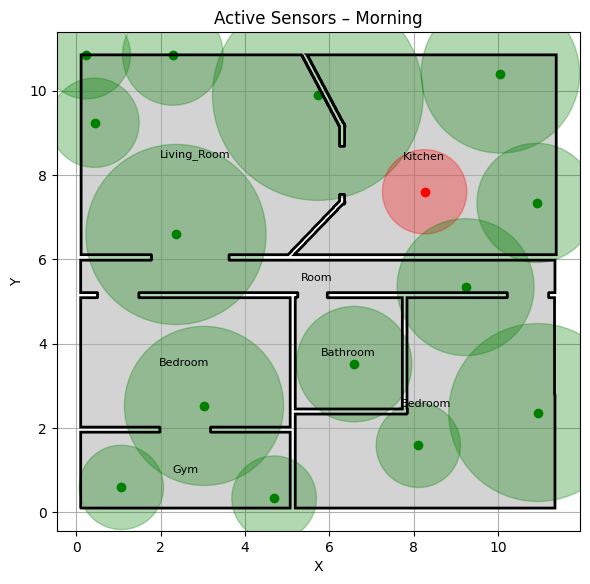

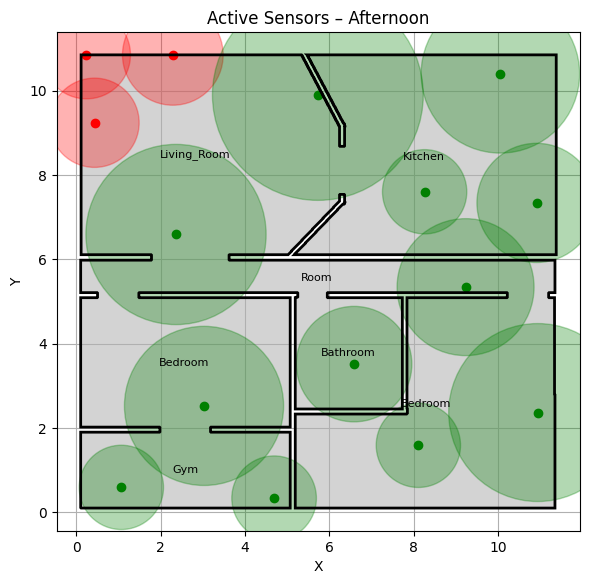

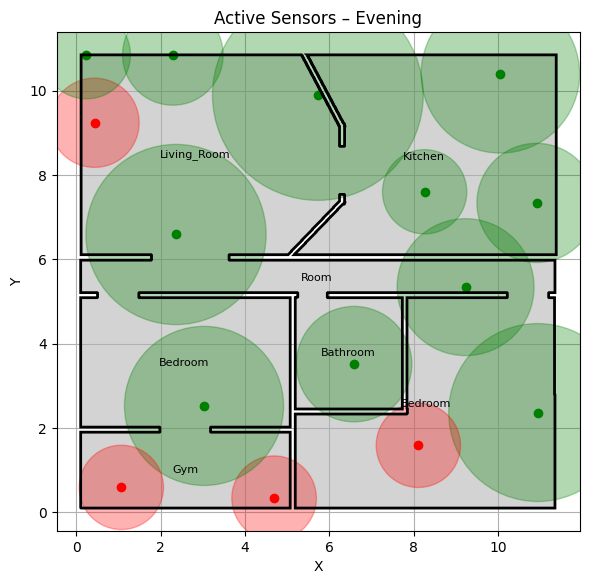

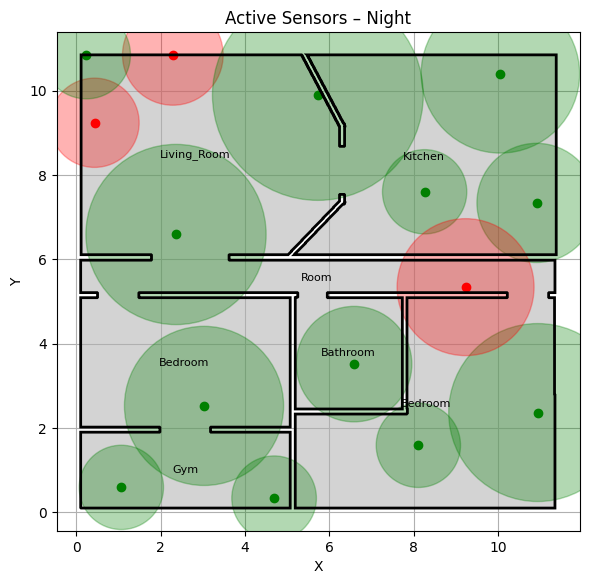

In [48]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
import pprint

# ------------ Load Layout and Sensor Data ------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
room_boxes     = layout_data["room_category"]  # { room_name: [ [x1,y1,x2,y2], ... ], ... }
min_x, min_y   = layout_data["bbox"]["min"]
max_x, max_y   = layout_data["bbox"]["max"]

with open("phase1_sensors.json", "r") as f:
    sensor_data = json.load(f)
sensor_positions = np.array(sensor_data["sensors"])  # each is [x, y, r]

# ------------ Activity Levels Prompt ------------
time_blocks     = ["Morning", "Afternoon", "Evening", "Night"]
activity_levels = {t: {} for t in time_blocks}

print("Enter activity levels (0.0–1.0):")
for t in time_blocks:
    print(f"\n– {t}")
    for room in room_boxes:
        while True:
            try:
                v = float(input(f"  {room}: "))
                if 0.0 <= v <= 1.0:
                    activity_levels[t][room] = v
                    break
            except ValueError:
                pass
            print("   → Enter a number between 0.0 and 1.0.")
print("\nFinal activity levels:")
pprint.pprint(activity_levels)

# ------------ Prepare Grid & Room Labels ------------
grid_res = 0.2
xs = np.arange(min_x, max_x, grid_res)
ys = np.arange(min_y, max_y, grid_res)
xx, yy = np.meshgrid(xs, ys)
GRID   = np.c_[xx.ravel(), yy.ravel()]

# label each grid point by the room it belongs to
room_label_map = np.full(len(GRID), "", dtype=object)
for room, boxes in room_boxes.items():
    for x1, y1, x2, y2 in boxes:
        mask = (GRID[:,0] >= x1)&(GRID[:,0] <= x2)&(GRID[:,1] >= y1)&(GRID[:,1] <= y2)
        room_label_map[mask] = room

# ------------ Activation Evaluation ------------
def evaluate_mask(mask, tkey):
    cov = np.zeros(len(GRID))
    for i, on in enumerate(mask):
        if not on: continue
        x0,y0,r = sensor_positions[i]
        d = np.hypot(GRID[:,0]-x0, GRID[:,1]-y0)
        cov += (d <= r).astype(float)
    w = np.array([activity_levels[tkey].get(room,0) for room in room_label_map])
    return (cov>0).dot(w), mask.sum()

def optimize_for(tkey, trials=500):
    best_s, best_m = -1, None
    N = len(sensor_positions)
    for _ in range(trials):
        m = np.random.rand(N)>0.5
        s,_ = evaluate_mask(m, tkey)
        if s>best_s:
            best_s, best_m = s, m.copy()
    return best_m

# ------------ Run & Save Phase 2 Results ------------
results = {}
for t in time_blocks:
    mask = optimize_for(t)
    results[t] = mask.tolist()

with open("phase2_results.json","w") as f:
    json.dump(results, f, indent=2)

# ------------ Visualization per Time Block ------------
for t in time_blocks:
    mask = np.array(results[t])
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect("equal")
    ax.set_title(f"Active Sensors – {t}")

    # draw floor fill and outline
    ax.add_patch(Polygon(polygon_coords, closed=True, facecolor="lightgray", zorder=0))
    ax.add_patch(Polygon(polygon_coords, closed=True, fill=False, edgecolor="black", linewidth=2, zorder=4))

    # label each room (skip 'Toilet' to avoid overlap)
    for room, boxes in room_boxes.items():
        if room.lower() == 'toilet':
            continue
        for x1,y1, x2,y2 in boxes:
            xc, yc = (x1+x2)/2, (y1+y2)/2
            ax.text(xc, yc, room, ha="center", va="center", fontsize=8, color="black", zorder=5)

    # draw sensors
    for i, on in enumerate(mask):
        x0,y0,r = sensor_positions[i]
        c = "green" if on else "red"
        ax.add_patch(plt.Circle((x0,y0), r, color=c, alpha=0.3, zorder=2))
        ax.plot(x0, y0, marker="o", color=c, zorder=3)

    # ax.set_xlim(min_x, max_x)
    # ax.set_ylim(min_y, max_y)

    padding_x = (max_x - min_x) * 0.05
    padding_y = (max_y - min_y) * 0.05
    ax.set_xlim(min_x - padding_x, max_x + padding_x)
    ax.set_ylim(min_y - padding_y, max_y + padding_y)

    ax.grid(True, zorder=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()
